In [2]:
import numpy as np
import qutip as qutip

from matplotlib import pyplot as plt

import time as time

import sys
import os
sys.path.append('../../../utils')

from tomography import coherent_state_tomography_copy as cst2
from quantum_utils import quantum_optics_utils as qou

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# First we define the parameters for reconstruction (and in this case artificial generation) of our noise state

The first of these parameters is the dimension of the truncated Fock space over which we're doing reconstruction (which is set by the expected number of noise photons, the assumption of thermal noise, and the relative extent of nonnegligible weight at Fock states of different photon numbers in the expected thermal photon distribution).

The other important parameters are the choice of IQ mesh size and - the points in the domain of the Q function of the noise signal at which you define your discrete set of coherent states to use as a basis for reconstruction. This mesh should be large enough to capture the nonnegligible region of support of the thermal noise IQ distribution given expected noise photon number and high enough resolution to capture curved features in the Q function.

In [4]:
noise_dim = 25
max_x = 5
mesh_size = 0.25

povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x,
                                                         mesh_size,
                                                         noise_dim,
                                                         cutoff=0)

Generating coherent state mesh took 7.751718759536743 s.


# Define the noise state and generate its Q function


In [5]:
avg_number_of_noise_photons = 1
rho_noise = qutip.thermal_dm(noise_dim, avg_number_of_noise_photons)
noise_q_func = qutip.qfunc(rho_noise, xs, ps, g=2)

# Flatten the povm and the q function and extract the multiplicative inverse of the completion of the POVM

In [6]:
flattened_povm = [povm_element for row_of_elements in povm for povm_element in row_of_elements]
flattened_noise_q_func = [value for row in noise_q_func for value in row]
G_inv = cst2.extract_G_inv_from_POVM(povm)

# Now reconstruct the noise state using its Q function as input to coherent state MLE

In [7]:
# Do noise state MLE
number_of_mle_iterations = 200
reconstructed_noise_state, _ = \
    cst2.perform_coherent_state_MLE_inline(
        flattened_povm,
        flattened_noise_q_func,
        G_inv,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1)

Inlined, flattened coherent state MLE of 1 photonic modes and truncated Fock space dimension 25 took 85.83252787590027 seconds.


In [8]:
# Now verify that the inlined MLE reconstructs the correct state
reconstruction_fidelity = qutip.fidelity(reconstructed_noise_state, rho_noise)
print('Reconstructed state fidelity: ' + str(reconstruction_fidelity))

Reconstructed state fidelity: 0.9985327247831708


# Reconstruct the noise state using the old method - not inlined or flattened

In [103]:
number_of_mle_iterations = 200
old_reconstructed_noise_state, _ = \
    cst2.perform_coherent_state_MLE(
        truncated_noisy_povm,
        noise_q_func,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1)

Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 25 took 88.5150899887085 seconds  for 200.


In [104]:
reconstruction_fidelity = qutip.fidelity(old_reconstructed_noise_state, rho_noise)
print('Non-inlined reconstructed state fidelity: ' + str(reconstruction_fidelity))

Non-inlined reconstructed state fidelity: 0.9985327246293803


# Now use the reconstructed noise state to generate a noisy POVM, and additionally use the ideal noise state to create the noisy Q function of the signal state

In [22]:
# Generate the POVM
max_x = 2 # We're going to be truncating anyways, so we can cut this max x down in size prematurely
mesh_size = 0.125
noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x,
                                                         mesh_size,
                                                         noise_dim,
                                                         cutoff=0,
                                                         noise_base=reconstructed_noise_state)

Generating coherent state mesh took 4.996783971786499 s.


In [23]:
# Generate the noisy signal data
signal_state = (qutip.basis(noise_dim, 0) + qutip.basis(noise_dim, 1)).unit()
noisy_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, avg_number_of_noise_photons, xs, ps)

# Using a truncated Fock space that anticipates the near-single photon nature of our signal, reduce our POVM set and perform truncated, inlined coherent state MLE

In [133]:
# Generate a reduced noisy POVM and the noisy Q function to the smaller Fock space dimension
truncated_dim = 3
truncated_noisy_povm = cst2.truncate_povm(noisy_povm, truncated_dim)

In [139]:
# Flatten the truncated povm and the Q function and thin them and compute G_inv
flattened_povm = [povm_el for povm_row in truncated_noisy_povm for povm_el in povm_row]
flattened_q_func = [qval for qrow in noisy_signal_data for qval in qrow]
thinned_truncated_povm, thinned_signal_q_func = cst2.thin_povm(flattened_povm, flattened_q_func, cutoff=0)
G_inv = cst2.extract_G_inv_from_flattened_POVM(thinned_truncated_povm)
psi_ideal = (qutip.basis(truncated_dim, 0) + qutip.basis(truncated_dim, 1)).unit()
rho_ideal = psi_ideal * psi_ideal.dag()

Number of povm elements prior to thinning: 289
Number of povm elements after thinning: 289


In [144]:
# Perform the truncated coherent state MLE reconstruction
number_of_mle_iterations = 10000
reconstructed_signal_state, intermediate_fidelities = \
    cst2.perform_coherent_state_MLE_inline(
        thinned_truncated_povm,
        thinned_signal_q_func,
        G_inv,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1,
        rho_ideal=rho_ideal,
        rho0=reconstructed_signal_state)

Inlined, flattened coherent state MLE of 1 photonic modes and truncated Fock space dimension 3 took 677.0686342716217 seconds.


In [145]:
ideal_signal_state = (qutip.basis(truncated_dim, 0) + qutip.basis(truncated_dim, 1)).unit()
reconstruction_fidelity = qutip.fidelity(reconstructed_signal_state, ideal_signal_state)
print('Truncated, thinned, MLE reconstructed state fidelity: ' + str(reconstruction_fidelity))

Truncated, thinned, MLE reconstructed state fidelity: 0.9267404572114037


<IPython.core.display.Javascript object>


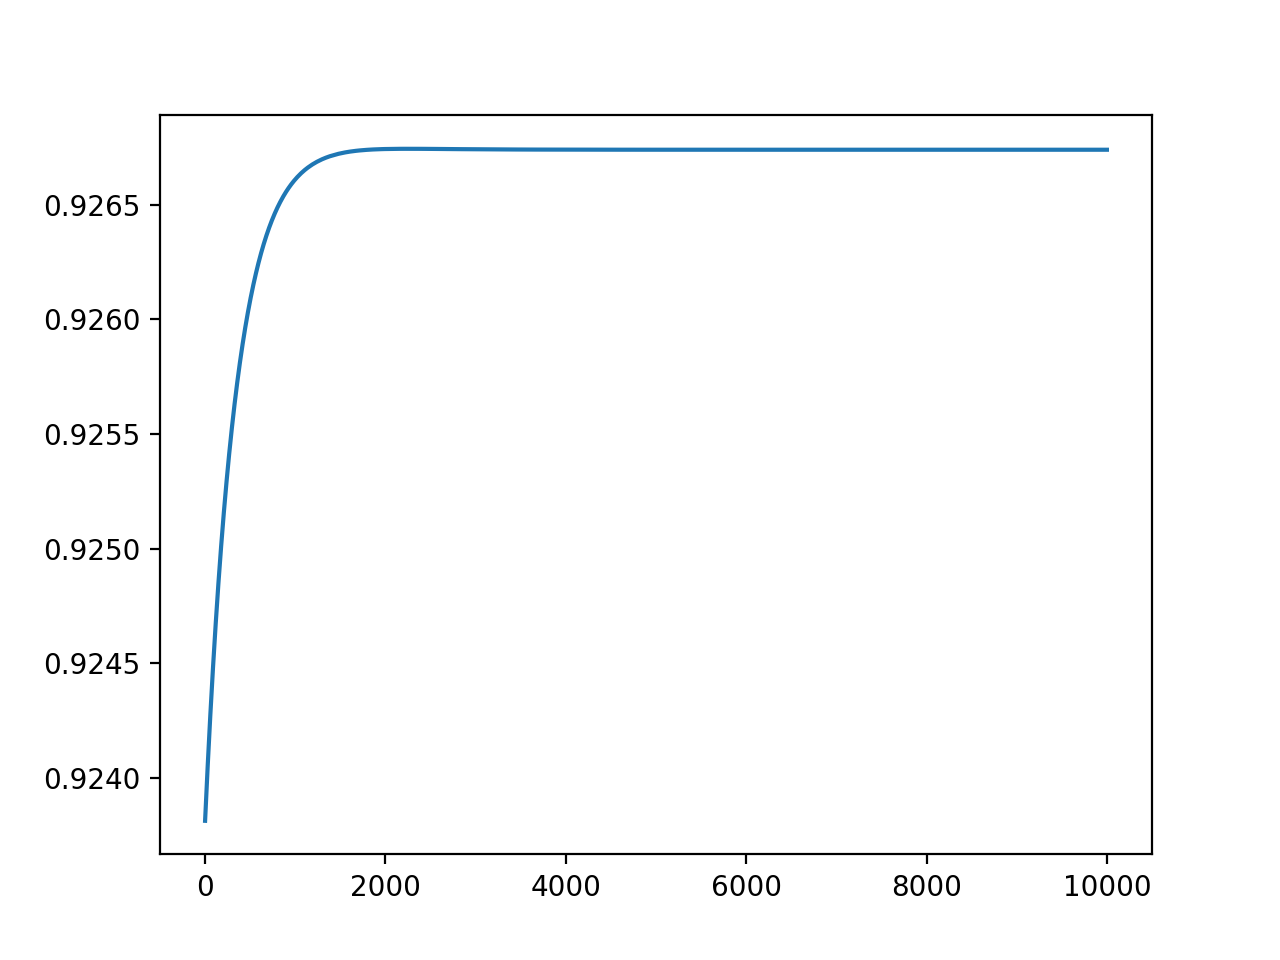

In [146]:
fig, ax = plt.subplots()
ax.plot(range(number_of_mle_iterations), intermediate_fidelities)

<IPython.core.display.Javascript object>


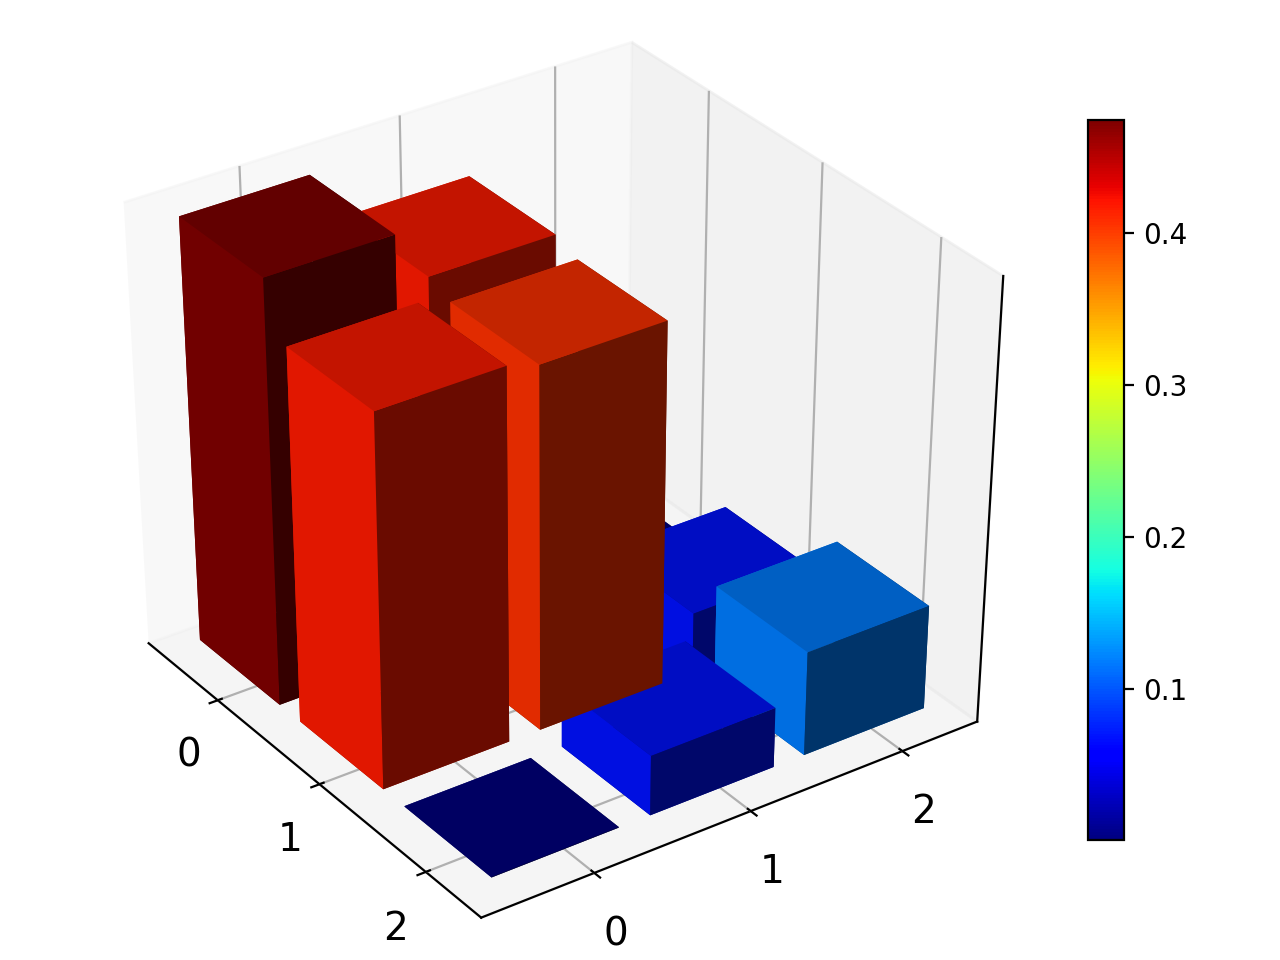

<IPython.core.display.Javascript object>


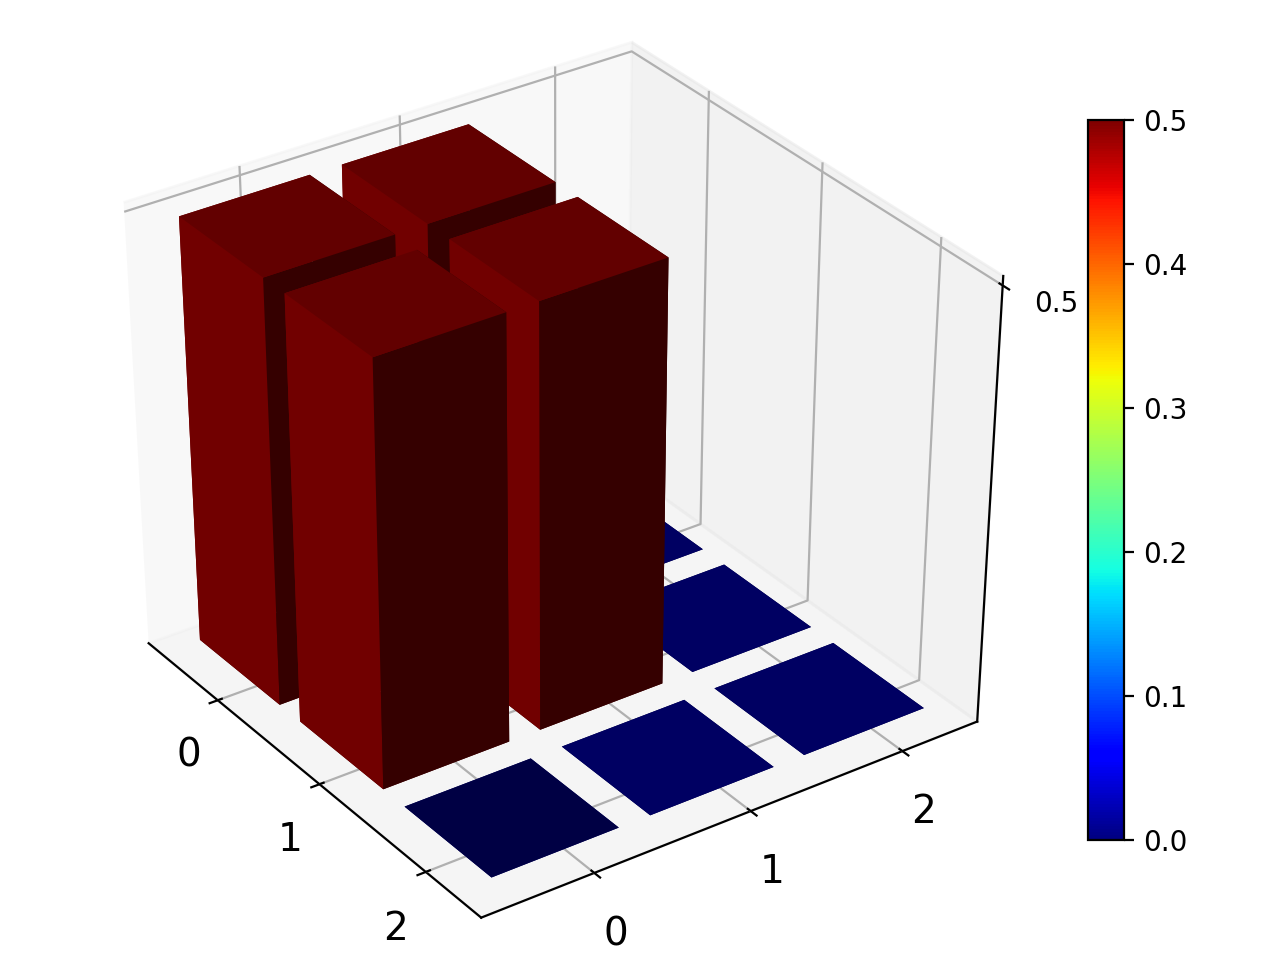

(<Figure size 640x480 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x13fd99dd0>)

In [147]:
qutip.visualization.matrix_histogram(reconstructed_signal_state)
qutip.visualization.matrix_histogram(ideal_signal_state*ideal_signal_state.dag())

# Using the untrucated POVM do the same reconstruction to compare performance

In [150]:
number_of_mle_iterations = 1000
old_reconstructed_signal_state, _ = \
    cst2.perform_coherent_state_MLE_inline(
        thinned_truncated_povm,
        thinned_signal_q_func,
        G_inv,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1)

Inlined, flattened coherent state MLE of 1 photonic modes and truncated Fock space dimension 3 took 66.4073691368103 seconds.


In [120]:
print(qutip.fidelity(old_reconstructed_signal_state, signal_state))

0.6657667494071488


<IPython.core.display.Javascript object>


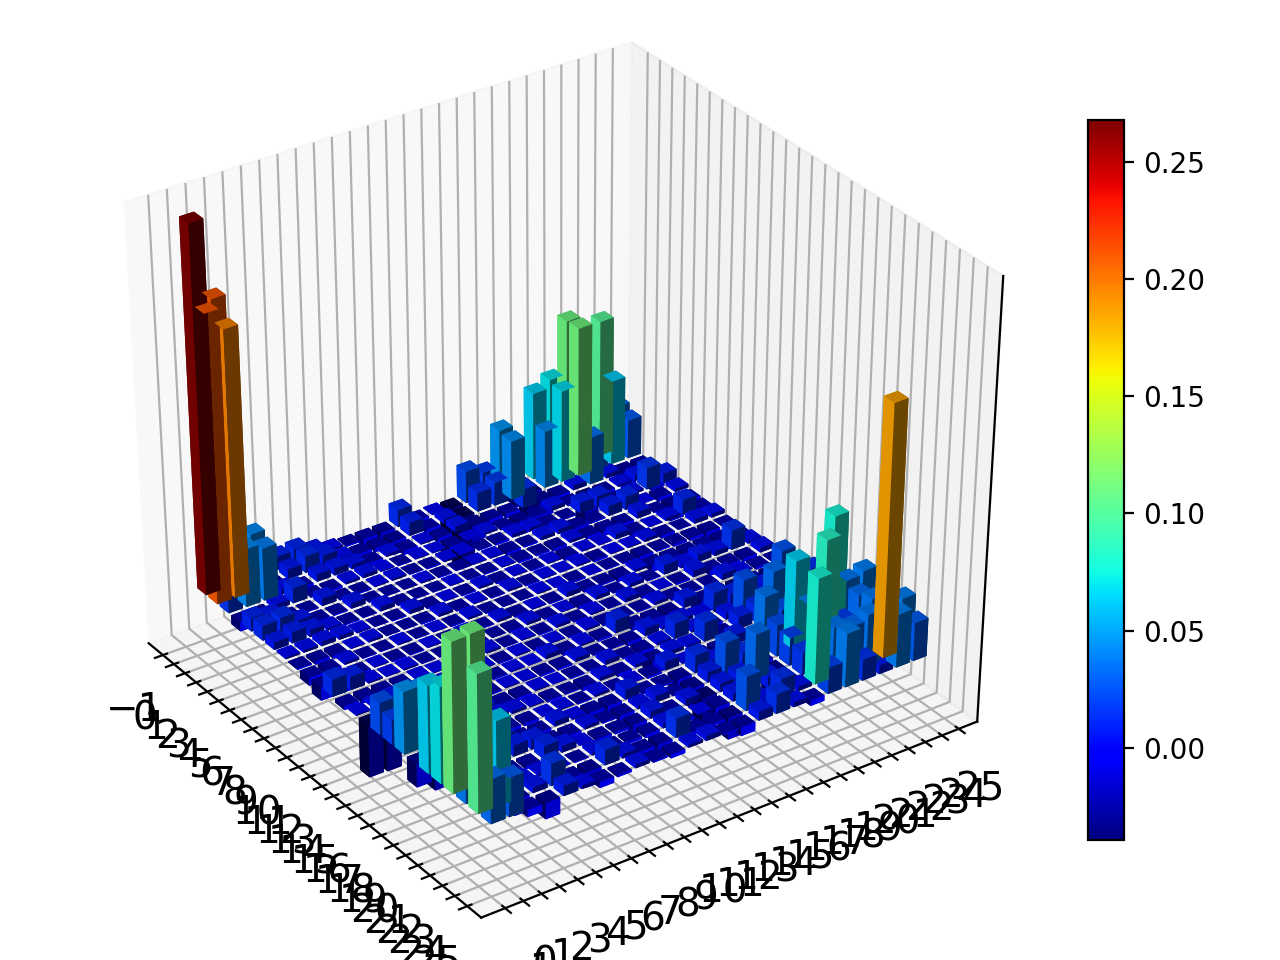

(<Figure size 640x480 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x14a6896d0>)

In [128]:
# Visualize the reconstructed state
qutip.visualization.matrix_histogram(old_reconstructed_signal_state)

# Try keeping track of up to 4 photons in our single mode

In [24]:
# Generate a reduced noisy POVM and the noisy Q function to the smaller Fock space dimension
truncated_dim = 3
truncated_noisy_povm = cst2.truncate_povm(noisy_povm, truncated_dim)
noisy_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, avg_number_of_noise_photons, xs, ps)
s0 = (qutip.basis(truncated_dim, 0) + qutip.basis(truncated_dim, 1)).unit()
rho_ideal = s0*s0.dag()

In [37]:
# running high res reconstruction longer
number_of_mle_iterations = 1000
reconstructed_signal_state_trunc3_higher_res2, intermediate_fidelities2, lls2 = \
    cst2.perform_coherent_state_MLE(
        truncated_noisy_povm,
        noisy_signal_data,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1,
        rho_ideal=rho_ideal,
        rho0=reconstructed_signal_state_trunc3_higher_res2)

Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 3 took 250.27314734458923 seconds  for 1000.


<IPython.core.display.Javascript object>


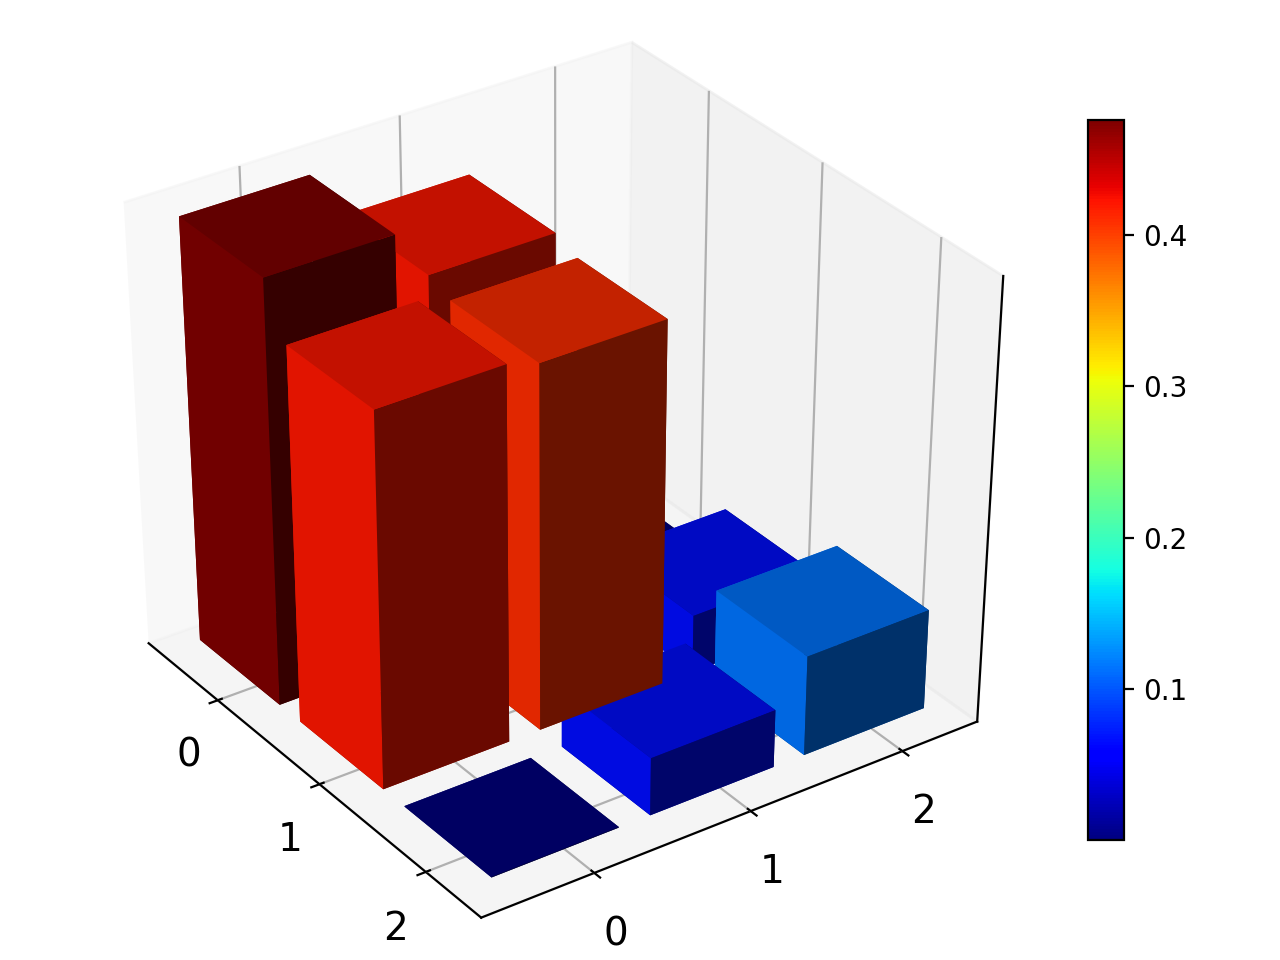

(<Figure size 640x480 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x135ddec10>)

In [38]:
# qutip.visualization.matrix_histogram(reconstructed_signal_state_trunc4)
qutip.visualization.matrix_histogram(reconstructed_signal_state_trunc3_higher_res2)

<IPython.core.display.Javascript object>


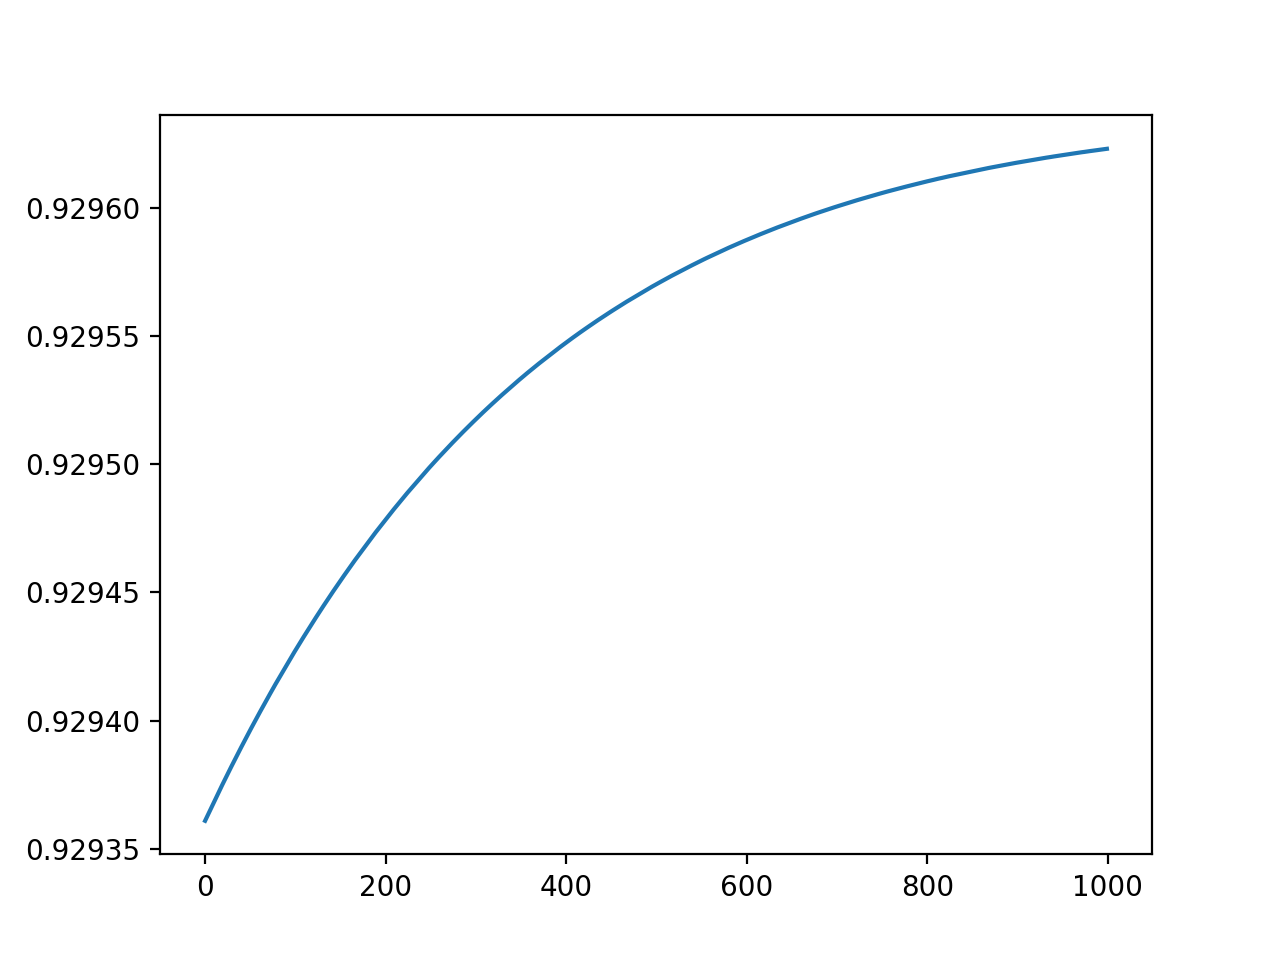

In [41]:
fig, ax = plt.subplots()
ax.plot(intermediate_fidelities2)